# Задача
Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-07-14 по 2023-07-20. Моя Задача как аналитика – оценить эффективность этого мероприятия.

1. Предположить, какие метрики должны были измениться во время флэшмоба и как. Почему? Предложить не менее 5 метрик.
2. Проверить, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - описать, как именно изменилась метрика и насколько.

## 1. Метрики которые могли изменится:
   1. DAU - по правилам флешмоба участники должны написать пост, а лучшие посты забирают призы. Соответственно пользователи, которые не были активны какое-то время могли вернуться. А значит число активных пользователей должно вырасти.
   2. Число просмотров - так как пользователи бы возвращились(1), значит и число просмотров росло бы с увеличением числа пользователей.
   3. Число лайков - победитель флешмоба определяется по лайкам. Значит пользователи, участвующие во флешмобе моглибы стимулировать рост лайков на своих постах(просить друзей поставть лайки и т.д.). Следовательно число лайков должно вырасти.
   4. CTR - так число лайков и просмотров должно вырасти(2, 3), значит и CTR, который определяется как отношении первого ко второму, тоже должен подрасти.
   5. Число событий на пользователя - так как растет число просмотров и число лайков, значит и число событий на пользователя должно увеличиваться.
   

In [11]:
import pandahouse as ph
import pandas as pd
from causalimpact import CausalImpact

2023-07-29 08:49:39.031633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 08:49:41.725582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

## CTR

In [86]:
# Извлекаем данные по CTR и преобразуем таблицу

query = '''
SELECT 
    toStartOfDay(time) day,
    countIf(action = 'like')/countIf(action = 'view') CTR
FROM 
    simulator_20230720.feed_actions

GROUP BY day
ORDER BY day
'''

ctr = ph.read_clickhouse(query=query, connection=connection)
ctr = ctr.set_index('day')
ctr.head()

,CTR
day,
2023-06-03,0.205182
2023-06-04,0.204174
2023-06-05,0.198605
2023-06-06,0.200007
2023-06-07,0.197783


In [88]:
# Строим модель, в качетсве pre_period берем все данные,которыми располагам, post_period - наш флешмоб
impact = CausalImpact(data=ctr, 
                      pre_period=['2023-06-03', '2023-07-13'], 
                      post_period=['2023-07-14', '2023-07-20'])

2023-07-29 11:32:56.210883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 11:32:56.253207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 11:32:57.103155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 11:

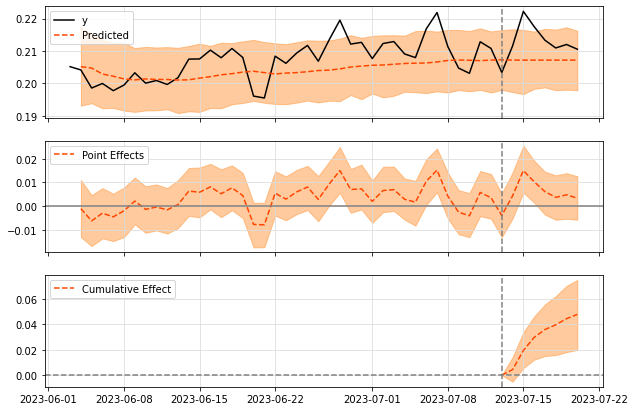

In [91]:
# Визуализауция результата
impact.plot()

In [92]:
# Результат
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.45 (0.01)
95% CI                    [0.2, 0.21]        [1.42, 1.48]

Absolute effect (s.d.)    0.01 (0.0)         0.05 (0.01)
95% CI                    [0.0, 0.01]        [0.02, 0.08]

Relative effect (s.d.)    3.29% (0.99%)      3.29% (0.99%)
95% CI                    [1.35%, 5.23%]     [1.35%, 5.23%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Мы можем наблюдать незначительное уыеличение CTR: на 0.01 в абсолютных значениях и на 3.3% в относительных. Хотя рост небольшой, но данное увеличение является статистически значимым. Вероятность того, что этот эффект произошел случайно равна 0. Значит этот рост вызван, проведенным флешмобом.

# Число событий на пользователя

In [94]:
q = """
SELECT toStartOfDay(time) day,
       COUNT(action) / count(distinct user_id) AS actions
FROM simulator_20230720.feed_actions
GROUP BY day
ORDER BY day
"""

actions = ph.read_clickhouse(query=q, connection=connection)
actions = actions.set_index('day')
actions.head()

,actions
day,
2023-06-03,10.436219
2023-06-04,33.773905
2023-06-05,40.735588
2023-06-06,38.375705
2023-06-07,45.258393


In [104]:
# Строим модель, в качетсве pre_period берем все данные,которыми располагам, post_period - наш флешмоб
impact = CausalImpact(data=actions, 
                      pre_period=['2023-06-03', '2023-07-13'],
                      post_period=['2023-07-14', '2023-07-20'])

2023-07-29 11:51:47.213148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 11:51:47.251025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 11:51:48.076295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 11:

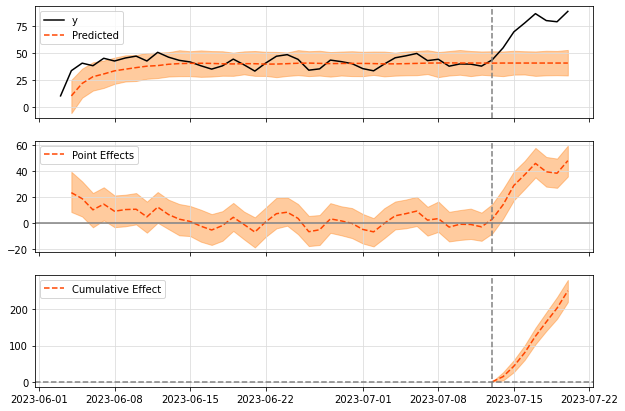

In [105]:
impact.plot()

In [106]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    76.74              537.15
Prediction (s.d.)         40.84 (2.37)       285.86 (16.62)
95% CI                    [36.01, 45.31]     [252.05, 317.18]

Absolute effect (s.d.)    35.9 (2.37)        251.29 (16.62)
95% CI                    [31.42, 40.73]     [219.97, 285.1]

Relative effect (s.d.)    87.91% (5.81%)     87.91% (5.81%)
95% CI                    [76.95%, 99.73%]   [76.95%, 99.73%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Мы наблюдаем значительный рост числа событий на пользователя: на 35.9 в абсолютных значениях и на 87.9% в относительных. Данное увеличение является статистически значимым. Вероятность того, что этот эффект произошел случайно равна 0. Значит этот рост вызван, проведенным флешмобом.

# DAU

In [107]:
q = """
SELECT toStartOfDay(time) AS day,
       count(DISTINCT user_id) AS dau
FROM simulator_20230720.feed_actions
GROUP BY day
ORDER BY day
"""

dau = ph.read_clickhouse(query=q, connection=connection)
dau = dau.set_index('day')
dau.head()

,dau
day,
2023-06-03,878
2023-06-04,2238
2023-06-05,3105
2023-06-06,3721
2023-06-07,4617


In [108]:
# Строим модель, в качетсве pre_period берем все данные,которыми располагам, post_period - наш флешмоб
impact = CausalImpact(data=dau,
                      pre_period=['2023-06-03', '2023-07-13'],
                      post_period=['2023-07-14', '2023-07-20'])

2023-07-29 11:52:44.864948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 11:52:44.898080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 11:52:45.663911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 11:

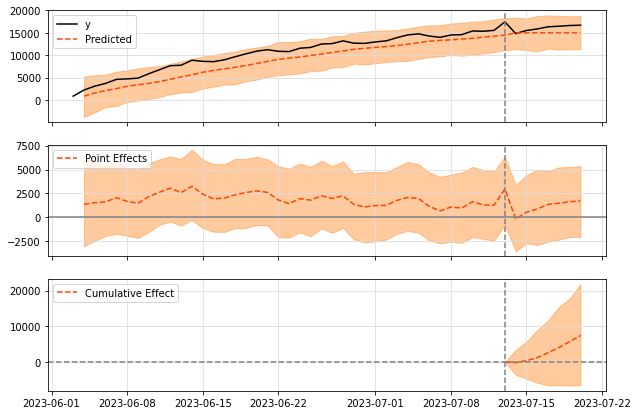

In [109]:
impact.plot()

In [110]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         14990.1 (1121.39)  104930.73 (7849.71)
95% CI                    [12712.04, 17107.8][88984.31, 119754.6]

Absolute effect (s.d.)    1062.61 (1121.39)  7438.27 (7849.71)
95% CI                    [-1055.09, 3340.67][-7385.6, 23384.69]

Relative effect (s.d.)    7.09% (7.48%)      7.09% (7.48%)
95% CI                    [-7.04%, 22.29%]   [-7.04%, 22.29%]

Posterior tail-area probability p: 0.16
Posterior prob. of a causal effect: 83.52%

For more details run the command: print(impact.summary('report'))


In [111]:
print(impact.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. In the absence of an
intervention, we would have expected an average response of 14990.1.
The 95% interval of this counterfactual prediction is [12712.04, 17107.8].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1062.61 with a 95% interval of
[-1055.09, 3340.67]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
Had the intervention not taken place, we would have expected
a sum of 104930.73. The 95% interval of this prediction is [88984.31, 119754.6].


The above results are given in terms of absolute numbers. In relative
terms, the response variab

Мы наблюдаем рост метрики DAU: на 1062 в абсолютных значениях и на 7% в относительных. Данное увеличение не является статистически значимым. Этот эффект мог произойти случайно с вероятностью 16.5%. То есть мы не можем уверенно сказать, что этот рост вызван, проведенным флешмобом. Возможно это связано с тем, что наше приложение существует недолго и метрика DAU растет с течением времени.

# Число лайков

In [112]:
q = """
SELECT 
    toStartOfDay(time) day,
    countIf(action = 'like') likes
FROM 
    simulator_20230720.feed_actions
GROUP BY day
ORDER BY day
"""

likes = ph.read_clickhouse(query=q, connection=connection)
likes = likes.set_index('day')
likes.head()

,likes
day,
2023-06-03,1560
2023-06-04,12816
2023-06-05,20958
2023-06-06,23800
2023-06-07,34504


In [113]:
# Строим модель, в качетсве pre_period берем все данные,которыми располагам, post_period - наш флешмоб
impact = CausalImpact(data=likes, 
                      pre_period=['2023-06-03', '2023-07-13'], 
                      post_period=['2023-07-14', '2023-07-20'])

2023-07-29 12:01:14.195052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 12:01:14.230654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 12:01:15.164247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 12:

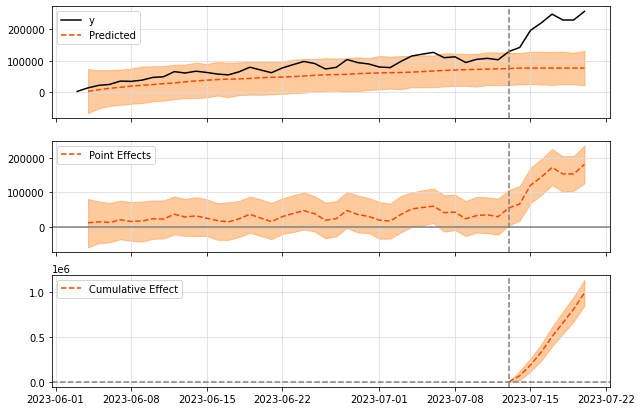

In [115]:
impact.plot()

In [116]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    218090.14          1526631.0
Prediction (s.d.)         76122.16 (11191.69)532855.12 (78341.85)
95% CI                    [54653.49, 98524.13][382574.42, 689668.9]

Absolute effect (s.d.)    141967.97 (11191.69)993775.88 (78341.85)
95% CI                    [119566.01, 163436.65][836962.1, 1144056.58]

Relative effect (s.d.)    186.5% (14.7%)     186.5% (14.7%)
95% CI                    [157.07%, 214.7%]  [157.07%, 214.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Наблюдается сильный рост числа лайков: на 141957 в абсолютных значениях и на 186% в относительных. Данное увеличение является статистически значимым. Вероятность того, что этот эффект произошел случайно равна 0.  Значит этот рост вызван, проведенным флешмобом.

In [117]:
q = """
SELECT 
    toStartOfDay(time) day,
    countIf(action = 'view') views
FROM 
    simulator_20230720.feed_actions
GROUP BY day
ORDER BY day
"""

views = ph.read_clickhouse(query=q, connection=connection)
views = views.set_index('day')
views.head()

,views
day,
2023-06-03,7603
2023-06-04,62770
2023-06-05,105526
2023-06-06,118996
2023-06-07,174454


In [118]:
# Строим модель, в качетсве pre_period берем все данные,которыми располагам, post_period - наш флешмоб
impact = CausalImpact(data=views, 
                      pre_period=['2023-06-03', '2023-07-13'], 
                      post_period=['2023-07-14', '2023-07-20'])

2023-07-29 12:21:50.574063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 12:21:50.607678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 12:21:51.334965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-07-29 12:

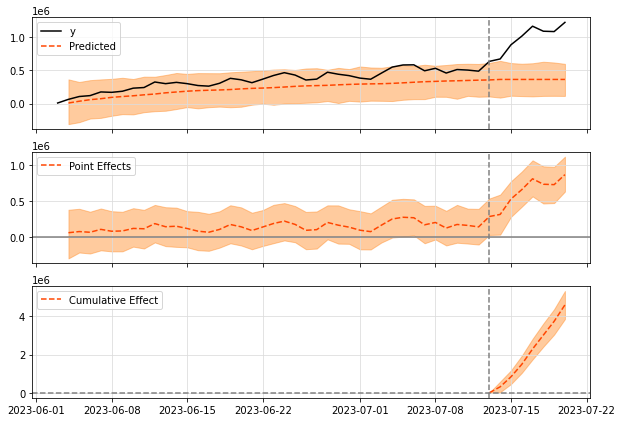

In [119]:
impact.plot()

In [120]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         363151.44 (52551.23)2542060.0 (367858.67)
95% CI                    [261137.42, 467134.52][1827961.93, 3269941.71]

Absolute effect (s.d.)    656795.88 (52551.23)4597571.0 (367858.67)
95% CI                    [552812.8, 758809.89][3869689.29, 5311669.08]

Relative effect (s.d.)    180.86% (14.47%)   180.86% (14.47%)
95% CI                    [152.23%, 208.95%] [152.23%, 208.95%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


С просмотрами ситуация аналогична лайкам. Наблюдается сильный рост числа просмотров: на 656795 в абсолютных значениях и на 180% в относительных. Данное увеличение является статистически значимым. Вероятность того, что этот эффект произошел случайно равна 0. Значит этот рост вызван, проведенным флешмобом.

# Выводы

По всем рассматриваемым метрикам мы видим рост. Для всех метрик, кроме DAU можно сделать вывод, что рост вызван проведенным флешмобом. Следовательно наш флешмоб был удачным. Благодаря нему получилось простимулировать пользователей и вернуть их в приложение, об этом свидетельствует рост метрик.